In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import yfinance as yf

stock_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2023-09-28"

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

data = pd.DataFrame(stock_data)



[*********************100%%**********************]  1 of 1 completed


In [ ]:
look_ahead_period = 7           # 7 daily candles
upper_barrier = 1.0
lower_barrier = -1.0

In [ ]:
data['pct_change'] = data['Adj Close'].pct_change()*100

In [ ]:
data['trend'] = np.zeros(len(data))
for i in range(len(data) - look_ahead_period):
  count = 0
  for j in range(look_ahead_period):
    if data['pct_change'][i+j]> upper_barrier:
      count+=1
    elif data['pct_change'][i+j]< lower_barrier:
      count-=1

  data['trend'][i] = (count/look_ahead_period)

<ipython-input-4-2e51efd0fdd4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trend'][i] = (count/look_ahead_period)


In [ ]:
data['trend_direction'] = np.zeros(len(data))
for i in range(len(data)):
  if np.abs(data['trend'][i])<0.2:
    data['trend_direction'][i] = 0
  elif data['trend'][i]>=0.2:
    data['trend_direction'][i] = 1
  else:
    data['trend_direction'][i] = -1

<ipython-input-5-c11060afa6b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trend_direction'][i] = -1
<ipython-input-5-c11060afa6b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trend_direction'][i] = 0
<ipython-input-5-c11060afa6b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trend_direction'][i] = 1


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,trend,trend_direction
Date,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600,NaN,-0.285714,-1.0
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800,0.172917,-0.142857,0.0
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000,-1.590631,-0.142857,0.0
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200,-0.184900,-0.142857,0.0
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800,0.664847,0.000000,0.0


In [ ]:
data = data.drop('2010-01-04')

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 19.2 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
model_garch = arch_model(data['pct_change'], vol='Garch', p=1, q=1)
results = model_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21033.438739279205
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2149366.5835737274
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6784.862242334151
Iteration:      4,   Func. Count:     28,   Neg. LLF: 6699.9270548885115
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1390276710.5792408
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6683.374532669044
Iteration:      7,   Func. Count:     46,   Neg. LLF: 6718.727877402517
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6651.033582596588
Iteration:      9,   Func. Count:     57,   Neg. LLF: 6650.914263146941
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6650.911615327252
Iteration:     11,   Func. Count:     67,   Neg. LLF: 6650.91143555232
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6650.911416647412
Iteration:     13,   Func. Count:     76,   Neg. LLF: 6650.9114166493455
Optimization terminated successfully    (Exit mode 0)
      

In [ ]:
forecast_horizon = 1  # Number of periods to forecast
forecasts = results.forecast(start=0, horizon=forecast_horizon)

# Get the conditional volatility forecast for the next period
forecasted_volatility = forecasts.variance.iloc[-1].values[-1]

# Define a threshold for classifying volatility
volatility_threshold = 0.02

# Classify as "High" or "Low" volatility
volatility_class = 'High' if forecasted_volatility > volatility_threshold else 'Low'

print(f"Forecasted Volatility: {forecasted_volatility:.4f}")
print(f"Volatility Class: {volatility_class}")


Forecasted Volatility: 2.5316
Volatility Class: High


In [ ]:
data['volatility_forecast'] = forecasts.variance

In [ ]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,pct_change,trend,trend_direction,volatility_forecast
Date,,,,,,,,,,
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800,0.172917,-0.142857,0.0,3.306742
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000,-1.590631,-0.142857,0.0,3.287022
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200,-0.184900,-0.142857,0.0,2.944968
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800,0.664847,0.000000,0.0,2.668158
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.369309,462229600,-0.882142,-0.142857,0.0,2.533426
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.296855,594459600,-1.137548,-0.285714,-1.0,2.486183
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.385678,605892000,1.410590,-0.285714,-1.0,2.420661
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.348695,432894000,-0.579156,-0.285714,-1.0,2.265761
2010-01-15,7.533214,7.557143,7.352500,7.354643,6.242594,594067600,-1.671233,-0.142857,0.0,2.444621


In [ ]:
data = data.reset_index()

In [ ]:
data['volatility_forecast'].mean()

3.222407659815655

In [ ]:
volatility_mean = data['volatility_forecast'].mean()

<Axes: xlabel='Date'>

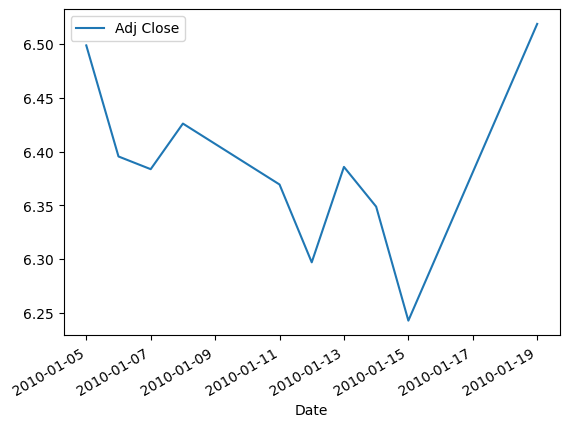

In [ ]:
data.iloc[:10].plot(y = 'Adj Close')

In [ ]:
for i in range(len(data)):
    if data['volatility_forecast'][i] > volatility_mean:
        data['volatility_regime'][i] = 1
    else:
        data['volatility_regime'][i] = 0  # Make sure to set a value for the 'else' case


<ipython-input-46-6dc91f99d22f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volatility_regime'][i] = 1
<ipython-input-46-6dc91f99d22f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volatility_regime'][i] = 0  # Make sure to set a value for the 'else' case


In [ ]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,trend,trend_direction,volatility_forecast,volatility_regime
0,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800,0.172917,-0.142857,0.0,3.306742,1.0
1,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000,-1.590631,-0.142857,0.0,3.287022,1.0
2,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200,-0.184900,-0.142857,0.0,2.944968,0.0
3,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800,0.664847,0.000000,0.0,2.668158,0.0
4,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.369309,462229600,-0.882142,-0.142857,0.0,2.533426,0.0
5,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.296855,594459600,-1.137548,-0.285714,-1.0,2.486183,0.0
6,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.385678,605892000,1.410590,-0.285714,-1.0,2.420661,0.0
7,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.348695,432894000,-0.579156,-0.285714,-1.0,2.265761,0.0
8,2010-01-15,7.533214,7.557143,7.352500,7.354643,6.242594,594067600,-1.671233,-0.142857,0.0,2.444621,0.0
9,2010-01-19,7.440357,7.685357,7.401429,7.680000,6.518757,730007600,4.423852,0.000000,0.0,4.166323,1.0
